In [1]:
import os
import cv2
import imutils

In [2]:
def pre_process_image(img, save_in_file, morph_size=(8, 8)):

    # get rid of the color
    pre = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Otsu threshold
    pre = cv2.threshold(pre, 250, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # dilate the text to make it solid spot
    cpy = pre.copy()
    struct = cv2.getStructuringElement(cv2.MORPH_RECT, morph_size)
    cpy = cv2.dilate(~cpy, struct, anchor=(-1, -1), iterations=1)
    pre = ~cpy

    if save_in_file is not None:
        cv2.imwrite(save_in_file, pre)
    return pre

In [3]:
def find_text_boxes(pre, min_text_height_limit=6, max_text_height_limit=40):
    # Looking for the text spots contours
    # OpenCV 3
    # img, contours, hierarchy = cv2.findContours(pre, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # OpenCV 4
    contours, hierarchy = cv2.findContours(pre, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Getting the texts bounding boxes based on the text size assumptions
    boxes = []
    for contour in contours:
        box = cv2.boundingRect(contour)
        h = box[3]

        if min_text_height_limit < h < max_text_height_limit:
            boxes.append(box)

    return boxes

In [4]:
def find_table_in_boxes(boxes, cell_threshold=10, min_columns=2):
    rows = {}
    cols = {}

    # Clustering the bounding boxes by their positions
    for box in boxes:
        (x, y, w, h) = box
        col_key = x // cell_threshold
        row_key = y // cell_threshold
        cols[row_key] = [box] if col_key not in cols else cols[col_key] + [box]
        rows[row_key] = [box] if row_key not in rows else rows[row_key] + [box]

    # Filtering out the clusters having less than 2 cols
    table_cells = list(filter(lambda r: len(r) >= min_columns, rows.values()))
    # Sorting the row cells by x coord
    table_cells = [list(sorted(tb)) for tb in table_cells]
    # Sorting rows by the y coord
    table_cells = list(sorted(table_cells, key=lambda r: r[0][1]))

    return table_cells

In [5]:
def build_lines(table_cells):
    if table_cells is None or len(table_cells) <= 0:
        return [], []

    max_last_col_width_row = max(table_cells, key=lambda b: b[-1][2])
    max_x = max_last_col_width_row[-1][0] + max_last_col_width_row[-1][2]

    max_last_row_height_box = max(table_cells[-1], key=lambda b: b[3])
    max_y = max_last_row_height_box[1] + max_last_row_height_box[3]

    hor_lines = []
    ver_lines = []

    for box in table_cells:
        x = box[0][0]
        y = box[0][1]
        hor_lines.append((x, y, max_x, y))

    for box in table_cells[0]:
        x = box[0]
        y = box[1]
        ver_lines.append((x, y, x, max_y))

    (x, y, w, h) = table_cells[0][-1]
    ver_lines.append((max_x, y, max_x, max_y))
    (x, y, w, h) = table_cells[0][0]
    hor_lines.append((x, max_y, max_x, max_y))

    return hor_lines, ver_lines

In [20]:
if __name__ == "__main__":
    in_file = os.path.join("data", "/home/vimal/Documents/table_detect_samples/unstructured tables/Input/0762096000.jpeg")
    pre_file = os.path.join("data", "pre.png")
    out_file = os.path.join("data", "out.png")

    img = cv2.imread(os.path.join(in_file))

    pre_processed = pre_process_image(img, pre_file)
    text_boxes = find_text_boxes(pre_processed)
    cells = find_table_in_boxes(text_boxes)
    hor_lines, ver_lines = build_lines(cells)

    # Visualize the result
    vis = img.copy()

    # for box in text_boxes:
    #     (x, y, w, h) = box
    #     cv2.rectangle(vis, (x, y), (x + w - 2, y + h - 2), (0, 255, 0), 1)

    for line in hor_lines:
        [x1, y1, x2, y2] = line
        cv2.line(vis, (x1, y1), (x2, y2), (0, 0, 255), 1)

    for line in ver_lines:
        [x1, y1, x2, y2] = line
        cv2.line(vis, (x1, y1), (x2, y2), (0, 0, 255), 1)

    cv2.imwrite(out_file, vis)

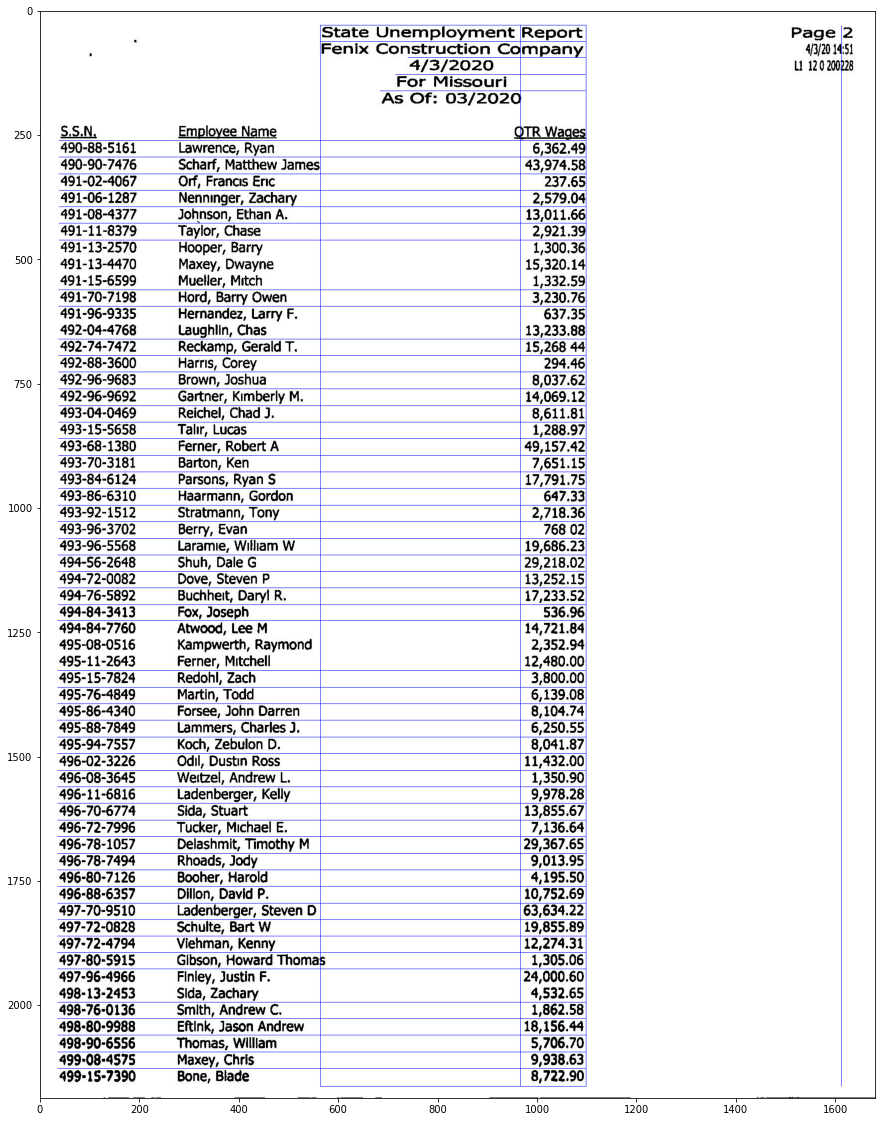

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(vis)

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib

In [11]:
font = cv2.FONT_HERSHEY_COMPLEX
img2 = cv2.imread('/home/vimal/Documents/table_detect_samples/samples/0100477000.jpeg', cv2.IMREAD_COLOR)

In [12]:
img = cv2.imread('/home/vimal/Documents/table_detect_samples/samples/0100477000.jpeg', cv2.IMREAD_GRAYSCALE)


In [13]:
_, threshold = cv2.threshold(img, 110, 255, cv2.THRESH_BINARY)

In [14]:
contours, _= cv2.findContours(threshold, cv2.RETR_TREE,
                               cv2.CHAIN_APPROX_SIMPLE)

In [16]:
for cnt in contours :
  
    approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)
  
    # draws boundary of contours.
    cv2.drawContours(img2, [approx], 0, (0, 0, 255), 5) 
  
    # Used to flatted the array containing
    # the co-ordinates of the vertices.
    n = approx.ravel() 
    i = 0
  
    for j in n :
        if(i % 2 == 0):
            x = n[i]
            y = n[i + 1]
  
            # String containing the co-ordinates.
            string = str(x) + " " + str(y) 
  
            if(i == 0):
                # text on topmost co-ordinate.
                cv2.putText(img2, "Arrow tip", (x, y),
                                font, 0.5, (255, 0, 0)) 
            else:
                # text on remaining co-ordinates.
                cv2.putText(img2, string, (x, y), 
                          font, 0.5, (0, 255, 0)) 
        i = i + 1
  
# Showing the final image.
cv2.imshow('image2', img2)
matplotlib.image.imsave(img2)


TypeError: imsave() missing 1 required positional argument: 'arr'

<Figure size 1440x1440 with 0 Axes>

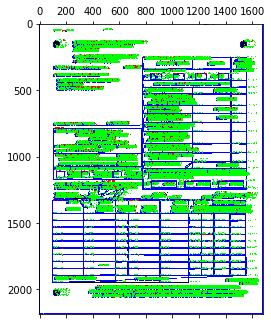

In [18]:
plt.figure(figsize=(20,20))
plt.matshow(img2)

In [ ]:
if cv2.waitKey(0) & 0xFF == ord('q'): 
    cv2.destroyAllWindows()

In [1]:
import cv2


In [2]:
def click_event(event, x, y, flags, params):
  
    # checking for left mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:
  
        # displaying the coordinates
        # on the Shell
        print(x, ' ', y)
  
        # displaying the coordinates
        # on the image window
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, str(x) + ',' +
                    str(y), (x,y), font,
                    1, (255, 0, 0), 2)
        cv2.imshow('image', img)
  
    # checking for right mouse clicks     
    if event==cv2.EVENT_RBUTTONDOWN:
  
        # displaying the coordinates
        # on the Shell
        print(x, ' ', y)
  
        # displaying the coordinates
        # on the image window
        font = cv2.FONT_HERSHEY_SIMPLEX
        b = img[y, x, 0]
        g = img[y, x, 1]
        r = img[y, x, 2]
        cv2.putText(img, str(b) + ',' +
                    str(g) + ',' + str(r),
                    (x,y), font, 1,
                    (255, 255, 0), 2)
        cv2.imshow('image', img)

In [8]:
if __name__=="__main__":
  
    # reading the image
    img = cv2.imread('/home/vimal/Documents/table_detect_samples/samples/0100477000.jpeg', 1)
  
    # displaying the image
    cv2.imshow('image', img)
  
    # setting mouse hadler for the image
    # and calling the click_event() function
    #cv2.setMouseCallback('image', click_event)

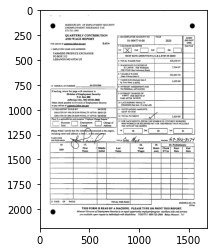

In [9]:
plt.imshow(img)

In [8]:
import uuid 


In [9]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [10]:
import numpy as np
import os, json, cv2, random

In [11]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.engine import DefaultTrainer
from detectron2.structures import BoxMode

from detectron2.utils.visualizer import ColorMode


In [12]:
ipdir = '/home/vimal/Documents/table_detect_samples/samples'
opdir = '/home/vimal/Documents/table_detect_samples/opt'

In [13]:
def predict(im, item):
    fileName=item
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #print(outputs["instances"].pred_boxes.tensor.numpy())
    path = "/home/vimal/Documents/table_detect_samples/opt"
    path1="/home/vimal/Documents/table_detect_samples/opt"
    cv2.imwrite(path1 + fileName + ".png", v.get_image()[:, :, ::-1])
    boxes = {}
    
    file = os.path.join(path,fileName)
    try:
        f=os.makedirs(file,exist_ok=True)
        print("Directory '%s' created " % file)
    except OSError as error:
        print("cannot create"%directory)
    i=1
    coords=[]
    for coordinates in outputs["instances"].to("cpu").pred_boxes:
        
        coordinates_array = []
        for k in coordinates:
            coordinates_array.append(int(k))
        boxes[uuid.uuid4().hex[:].upper()] = coordinates_array
        coords.append(coordinates_array)
    
    for k,v in boxes.items():

        crop_img = im[v[1]:v[3], v[0]:v[2], :]
        #print(v[1],v[3], v[0],v[2])
        #cv2_imshow(crop_img)
        crop_width,crop_height=crop_img.shape[0],crop_img.shape[1]
        if crop_width>crop_height:
            img_rot=cv2.rotate(crop_img,cv2.ROTATE_90_CLOCKWISE)
            
        #------for naming the images------#v[1]=y,v[3]=y+h, v[0]=x,v[2]=x+w
            margin = 0
        
            ymin = max(v[1]-margin,0)
            ymax =v[3]+margin
            xmin = max(v[0] - margin,0)
            xmax = v[2]+margin
            #print(ymin,ymax,xmin,xmax)
            cv2.imwrite(file+'/'+str(i)+'_'+str(xmin)+'_'+str(ymin)+'_'+str(xmin)+'_'+str(ymax)+'_'+str(xmax)+'_'+str(ymin)+'_'+str(xmax)+'_'+str(ymax)+ '.png', img_rot)
            i=i+1

    
    return outputs




In [14]:
dirs = os.listdir(ipdir)


for item in dirs:
    if os.path.isfile(ipdir+item):
        im = cv2.imread(ipdir+item)
        print(item)
        f, e = os.path.splitext(ipdir+item)
        #width,height = im.shape[1],im.shape[0]
        item = item[:-4]
        predict(im, item)

In [15]:
def get_edges(img):
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  bitwised_img = cv2.bitwise_not(gray_img)
  guassian_img = cv2.GaussianBlur(bitwised_img, (5, 5), 0)
  bilateral_img = cv2.bilateralFilter(guassian_img, 11, 17, 17)
  t, thresh_bin = cv2.threshold(bilateral_img, 0, 255, cv2.THRESH_OTSU)
  canny = cv2.Canny(thresh_bin, 0.5 * t, t)
  dilated = cv2.dilate(canny,
                       cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3)))
  medianed = cv2.medianBlur(dilated, 3)
  # Edges will be discontinous so dialtion will be make them contionuous
  return medianed

In [16]:
img = '/home/vimal/Documents/table_detect_samples/samples/0154742000.jpeg'

In [17]:
get_edges(img)

TypeError: Expected Ptr<cv::UMat> for argument 'src'

In [8]:
import os
import cv2
import imutils

In [9]:
def pre_process_image(img, save_in_file, morph_size=(8, 8)):

    # get rid of the color
    pre = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Otsu threshold
    pre = cv2.threshold(pre, 250, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # dilate the text to make it solid spot
    cpy = pre.copy()
    struct = cv2.getStructuringElement(cv2.MORPH_RECT, morph_size)
    cpy = cv2.dilate(~cpy, struct, anchor=(-1, -1), iterations=1)
    pre = ~cpy

    if save_in_file is not None:
        cv2.imwrite(save_in_file, pre)
    return pre

In [10]:
def find_text_boxes(pre, min_text_height_limit=6, max_text_height_limit=40):
    # Looking for the text spots contours
    # OpenCV 3
    # img, contours, hierarchy = cv2.findContours(pre, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # OpenCV 4
    contours, hierarchy = cv2.findContours(pre, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Getting the texts bounding boxes based on the text size assumptions
    boxes = []
    for contour in contours:
        box = cv2.boundingRect(contour)
        h = box[3]

        if min_text_height_limit < h < max_text_height_limit:
            boxes.append(box)

    return boxes

In [11]:
def find_table_in_boxes(boxes, cell_threshold=10, min_columns=2):
    rows = {}
    cols = {}

    # Clustering the bounding boxes by their positions
    for box in boxes:
        (x, y, w, h) = box
        col_key = x // cell_threshold
        row_key = y // cell_threshold
        cols[row_key] = [box] if col_key not in cols else cols[col_key] + [box]
        rows[row_key] = [box] if row_key not in rows else rows[row_key] + [box]

    # Filtering out the clusters having less than 2 cols
    table_cells = list(filter(lambda r: len(r) >= min_columns, rows.values()))
    # Sorting the row cells by x coord
    table_cells = [list(sorted(tb)) for tb in table_cells]
    # Sorting rows by the y coord
    table_cells = list(sorted(table_cells, key=lambda r: r[0][1]))

    return table_cells

In [12]:
def build_lines(table_cells):
    if table_cells is None or len(table_cells) <= 0:
        return [], []

    max_last_col_width_row = max(table_cells, key=lambda b: b[-1][2])
    max_x = max_last_col_width_row[-1][0] + max_last_col_width_row[-1][2]

    max_last_row_height_box = max(table_cells[-1], key=lambda b: b[3])
    max_y = max_last_row_height_box[1] + max_last_row_height_box[3]

    hor_lines = []
    ver_lines = []

    for box in table_cells:
        x = box[0][0]
        y = box[0][1]
        hor_lines.append((x, y, max_x, y))

    for box in table_cells[0]:
        x = box[0]
        y = box[1]
        ver_lines.append((x, y, x, max_y))

    (x, y, w, h) = table_cells[0][-1]
    ver_lines.append((max_x, y, max_x, max_y))
    (x, y, w, h) = table_cells[0][0]
    hor_lines.append((x, max_y, max_x, max_y))

    return hor_lines, ver_lines

In [17]:
if __name__ == "__main__":
    in_file = os.path.join("/home/vimal/Documents/table_detect_samples/in", "0100477000.jpeg")
    pre_file = os.path.join("/home/vimal/Documents/table_detect_samples/pre", "0100477000.jpeg")
    out_file = os.path.join("/home/vimal/Documents/table_detect_samples/out", "0100477000.jpeg")

    img = cv2.imread(os.path.join(in_file))

    pre_processed = pre_process_image(img, pre_file)
    text_boxes = find_text_boxes(pre_processed)
    cells = find_table_in_boxes(text_boxes)
    hor_lines, ver_lines = build_lines(cells)

    # Visualize the result
    vis = img.copy()

    # for box in text_boxes:
    #     (x, y, w, h) = box
    #     cv2.rectangle(vis, (x, y), (x + w - 2, y + h - 2), (0, 255, 0), 1)

    for line in hor_lines:
        [x1, y1, x2, y2] = line
        cv2.line(vis, (x1, y1), (x2, y2), (0, 0, 255), 1)

    for line in ver_lines:
        [x1, y1, x2, y2] = line
        cv2.line(vis, (x1, y1), (x2, y2), (0, 0, 255), 1)

    cv2.imwrite(out_file, vis)

In [22]:
import os
import cv2

def find_tables(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    #image = cv2.imread(image)
    #blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    blurred = cv2.GaussianBlur(image,(17,17),cv2.BORDER_DEFAULT)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE,
    )

    MIN_TABLE_AREA = 1e5
    contours = [c for c in contours if cv2.contourArea(c) > MIN_TABLE_AREA]
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.1 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

    # The link where a lot of this code was borrowed from recommends an
    # additional step to check the number of "joints" inside this bounding rectangle.
    # A table should have a lot of intersections. We might have a rectangular image
    # here though which would only have 4 intersections, 1 at each corner.
    # Leaving that step as a future TODO if it is ever necessary.
    images = [image[y:y+h, x:x+w] for x, y, w, h in bounding_rects]
    return images

def main(files):
    results = []
    for f in files:
        directory, filename = os.path.split(f)
        image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        tables = find_tables(image)
        files = []
        filename_sans_extension = os.path.splitext(filename)[0]
        if tables:
            os.makedirs(os.path.join(directory, filename_sans_extension), exist_ok=True)
        for i, table in enumerate(tables):
            table_filename = "/home/vimal/Documents/table_detect_samples/samples/0782492000.jpeg".format(i)
            table_filepath = os.path.join(
                directory, filename_sans_extension, table_filename
            )
            files.append(table_filepath)
            cv2.imwrite(table_filepath, table)
        if tables:
            results.append((f, files))
    # Results is [[<input image>, [<images of detected tables>]]]
    return results

In [23]:
image = '/home/vimal/Documents/table_detect_samples/pre/0782492000.jpeg'

In [24]:
path = '/home/vimal/Documents/table_detect_samples/samples'

In [25]:
files = os.listdir(path)

In [26]:
main(files)

error: OpenCV(4.5.1) /tmp/pip-req-build-ms668fyv/opencv/modules/imgproc/src/smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'GaussianBlur'


In [38]:
BLUR_KERNEL_SIZE = (17, 17)
STD_DEV_X_DIRECTION = 0
STD_DEV_Y_DIRECTION = 0

In [39]:
image = '/home/vimal/Documents/table_detect_samples/pre/0782492000.jpeg'

In [41]:
blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)


TypeError: Expected Ptr<cv::UMat> for argument 'src'

In [1]:
import os
import cv2
import numpy as np

In [5]:
def find_tables(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    #img_gray = cv2.cvtColor(np.float32(img_rgb), cv2.COLOR_BGR2GRAY)


    blurred = cv2.GaussianBlur(cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2GRAY), BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION,STD_DEV_Y_DIRECTION)
    #gray = cv2.cvtColor(np.float32(imgUMat), cv2.COLOR_RGB2GRAY)

    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE,
    )

    MIN_TABLE_AREA = 1e5
    contours = [c for c in contours if cv2.contourArea(c) > MIN_TABLE_AREA]
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.1 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

    # The link where a lot of this code was borrowed from recommends an
    # additional step to check the number of "joints" inside this bounding rectangle.
    # A table should have a lot of intersections. We might have a rectangular image
    # here though which would only have 4 intersections, 1 at each corner.
    # Leaving that step as a future TODO if it is ever necessary.
    images = [image[y:y+h, x:x+w] for x, y, w, h in bounding_rects]
    return images
def main(files):
    results = []
    for f in files:
        directory, filename = os.path.split(f)
        image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        tables = find_tables(image)
        files = []
        filename_sans_extension = os.path.splitext(filename)[0]
        if tables:
            os.makedirs(os.path.join(directory, filename_sans_extension), exist_ok=True)
        for i, table in enumerate(tables):
            table_filename = "table-{:03d}.png".format(i)
            table_filepath = os.path.join(
                directory, filename_sans_extension, table_filename
            )
            files.append(table_filepath)
            cv2.imwrite(table_filepath, table)
        if tables:
            results.append((f, files))
    # Results is [[<input image>, [<images of detected tables>]]]
    return results

In [6]:
image = '/home/vimal/Documents/table_detect_samples/pre/0782492000.jpeg'

In [7]:
find_tables(image)

ValueError: could not convert string to float: '/home/vimal/Documents/table_detect_samples/pre/0782492000.jpeg'

In [46]:
files = os.listdir('/home/vimal/Documents/table_detect_samples/pre')

In [47]:
main(files)

error: OpenCV(4.5.1) /tmp/pip-req-build-ms668fyv/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [2]:
import os
import setuptools

In [3]:
this_dir = os.path.abspath(os.path.dirname('/home/vimal/Documents/python/ocr-table'))
with open(os.path.join(this_dir, "README.txt"), encoding="utf-8") as f:
    long_description = f.read()

setuptools.setup(
    name="table_ocr",
    version="0.2.5",
    author="Eric Ihli",
    author_email="eihli@owoga.com",
    description="Extract text from tables in images.",
    long_description=long_description,
    long_description_content_type="text/plain",
    url="https://github.com/eihli/image-table-ocr",
    packages=setuptools.find_packages(),
    package_data={
        "table_ocr": ["tessdata/table-ocr.traineddata", "tessdata/eng.traineddata"]
    },
    classifiers=[
        "Programming Language :: Python :: 3",
        "License :: OSI Approved :: MIT License",
        "Operating System :: OS Independent",
    ],
    install_requires=["pytesseract~=0.3", "opencv-python~=4.2", "numpy~=1.19", "requests>=2"],
    python_requires=">=3.6",
)


FileNotFoundError: [Errno 2] No such file or directory: '/home/vimal/Documents/python/README.txt'

In [37]:
import tableocr

ModuleNotFoundError: No module named 'tableocr'

In [32]:
import os
import sys

import requests
import table_ocr.util
import table_ocr.extract_tables
import table_ocr.extract_cells
import table_ocr.ocr_image
import table_ocr.ocr_to_csv

ModuleNotFoundError: No module named 'table_ocr'

In [6]:
pip install table_ocr


  Using cached table_ocr-0.2.5-py3-none-any.whl (33.4 MB)
You should consider upgrading via the '/home/vimal/Documents/python/cde_venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [13]:
url = 'https://data.templateroller.com/pdf_docs_html/2029/20291/2029195/form-modes-4-quarterly-contribution-and-wage-report-missouri.png'

In [14]:
def download_image_to_tempdir(url, filename=None):
    if filename is None:
        filename = os.path.basename(url)
    response = requests.get(url, stream=True)
    tempdir = table_ocr.util.make_tempdir("demo")
    filepath = os.path.join(tempdir, filename)
    with open(filepath, 'wb') as f:
        for chunk in response.iter_content():
            f.write(chunk)
    return filepath

In [15]:
def main(url):
    image_filepath = download_image_to_tempdir(url)
    image_tables = table_ocr.extract_tables.main([image_filepath])
    print("Running `{}`".format(f"extract_tables.main([{image_filepath}])."))
    print("Extracted the following tables from the image:")
    print(image_tables)
    for image, tables in image_tables:
        print(f"Processing tables for {image}.")
        for table in tables:
            print(f"Processing table {table}.")
            cells = table_ocr.extract_cells.main(table)
            ocr = [
                table_ocr.ocr_image.main(cell, None)
                for cell in cells
            ]
            print("Extracted {} cells from {}".format(len(ocr), table))
            print("Cells:")
            for c, o in zip(cells[:3], ocr[:3]):
                with open(o) as ocr_file:
                    # Tesseract puts line feeds at end of text.
                    # Stript it out.
                    text = ocr_file.read().strip()
                    print("{}: {}".format(c, text))
            # If we have more than 3 cells (likely), print an ellipses
            # to show that we are truncating output for the demo.
            if len(cells) > 3:
                print("...")
            return table_ocr.ocr_to_csv.text_files_to_csv(ocr)


In [16]:
if __name__ == "__main__":
    csv_output = main(sys.argv[1])
    print()
    print("Here is the entire CSV output:")
    print()
    print(csv_output)

MissingSchema: Invalid URL '-f': No schema supplied. Perhaps you meant http://-f?

In [ ]:
https://data.templateroller.com/pdf_docs_html/2029/20291/2029195/form-modes-4-quarterly-contribution-and-wage-report-missouri.png

In [16]:
import cv2
import numpy

In [17]:
src = cv2.imread('/home/vimal/Documents/table_detect_samples/pre/0782492000.jpeg', cv2.IMREAD_UNCHANGED)


In [18]:
dst = cv2.GaussianBlur(src,(5,5),cv2.BORDER_DEFAULT)
 

In [19]:
import matplotlib.pyplot as plt

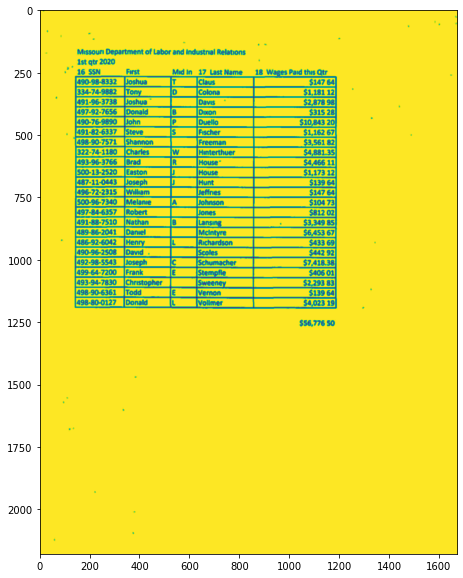

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(dst)

In [31]:
import cv2
import os

def extract_cell_images_from_table(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(blurred,AX_COLOR_VAL,      cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,
    )
    
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.05 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    
    # Filter out contours that aren't rectangular. Those that aren't rectangular
    # are probably noise.
    approx_rects = [p for p in approx_polys if len(p) == 4]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]
    
    # Filter out rectangles that are too narrow or too short.
    MIN_RECT_WIDTH = 40
    MIN_RECT_HEIGHT = 10
    bounding_rects = [
        r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
    ]
    
    # The largest bounding rectangle is assumed to be the entire table.
    # Remove it from the list. We don't want to accidentally try to OCR
    # the entire table.
    largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
    bounding_rects = [b for b in bounding_rects if b is not largest_rect]
    
    cells = [c for c in bounding_rects]
    def cell_in_same_row(c1, c2):
        c1_center = c1[1] + c1[3] - c1[3] / 2
        c2_bottom = c2[1] + c2[3]
        c2_top = c2[1]
        return c2_top < c1_center < c2_bottom
    
    orig_cells = [c for c in cells]
    rows = []
    while cells:
        first = cells[0]
        rest = cells[1:]
        cells_in_same_row = sorted(
            [
                c for c in rest
                if cell_in_same_row(c, first)
            ],
            key=lambda c: c[0]
        )
    
        row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
        rows.append(row_cells)
        cells = [
            c for c in rest
            if not cell_in_same_row(c, first)
        ]
    
    # Sort rows by average height of their center.
    def avg_height_of_center(row):
        centers = [y + h - h / 2 for x, y, w, h in row]
        return sum(centers) / len(centers)
    
    rows.sort(key=avg_height_of_center)
    cell_images_rows = []
    for row in rows:
        cell_images_row = []
        for x, y, w, h in row:
            cell_images_row.append(image[y:y+h, x:x+w])
        cell_images_rows.append(cell_images_row)
    return cell_images_rows

def main(f):
    results = []
    directory, filename = os.path.split(f)
    table = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    rows = extract_cell_images_from_table(table)
    cell_img_dir = os.path.join(directory, "cells")
    os.makedirs(cell_img_dir, exist_ok=True)
    paths = []
    for i, row in enumerate(rows):
        for j, cell in enumerate(row):
            cell_filename = "{:03d}-{:03d}.png".format(i, j)
            path = os.path.join(cell_img_dir, cell_filename)
            cv2.imwrite(path, cell)
            paths.append(path)
    return paths

In [17]:
image = '/home/vimal/Documents/table_detect_samples/pre/0782492000.jpeg'
image = cv2.imread(image,0)

In [15]:
image.create(rows, cols, CV_8UC1);
image = imread(image-file, CV_8UC1)

AttributeError: 'str' object has no attribute 'create'

In [18]:
image = cv2.imread(image,0)

In [19]:
extract_cell_images_from_table(image)

[]

In [11]:
import cv2
import os

def extract_cell_images_from_table(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,
    )
    
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.05 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    
    # Filter out contours that aren't rectangular. Those that aren't rectangular
    # are probably noise.
    approx_rects = [p for p in approx_polys if len(p) == 4]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]
    
    # Filter out rectangles that are too narrow or too short.
    MIN_RECT_WIDTH = 40
    MIN_RECT_HEIGHT = 10
    bounding_rects = [
        r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
    ]
    
    # The largest bounding rectangle is assumed to be the entire table.
    # Remove it from the list. We don't want to accidentally try to OCR
    # the entire table.
    largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
    bounding_rects = [b for b in bounding_rects if b is not largest_rect]
    
    cells = [c for c in bounding_rects]
    def cell_in_same_row(c1, c2):
        c1_center = c1[1] + c1[3] - c1[3] / 2
        c2_bottom = c2[1] + c2[3]
        c2_top = c2[1]
        return c2_top < c1_center < c2_bottom
    
    orig_cells = [c for c in cells]
    rows = []
    while cells:
        first = cells[0]
        rest = cells[1:]
        cells_in_same_row = sorted(
            [
                c for c in rest
                if cell_in_same_row(c, first)
            ],
            key=lambda c: c[0]
        )
    
        row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
        rows.append(row_cells)
        cells = [
            c for c in rest
            if not cell_in_same_row(c, first)
        ]
    
    # Sort rows by average height of their center.
    def avg_height_of_center(row):
        centers = [y + h - h / 2 for x, y, w, h in row]
        return sum(centers) / len(centers)
    
    rows.sort(key=avg_height_of_center)
    cell_images_rows = []
    for row in rows:
        cell_images_row = []
        for x, y, w, h in row:
            cell_images_row.append(image[y:y+h, x:x+w])
        cell_images_rows.append(cell_images_row)
    return cell_images_rows

def main(f):
    results = []
    directory, filename = os.path.split(f)
    table = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    rows = extract_cell_images_from_table(table)
    cell_img_dir = os.path.join(directory, "cells")
    os.makedirs(cell_img_dir, exist_ok=True)
    paths = []
    for i, row in enumerate(rows):
        for j, cell in enumerate(row):
            cell_filename = "{:03d}-{:03d}.png".format(i, j)
            path = os.path.join(cell_img_dir, cell_filename)
            cv2.imwrite(path, cell)
            paths.append(path)
    return paths

In [6]:
import os
import cv2

def find_tables(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE,
    )

    MIN_TABLE_AREA = 1e5
    contours = [c for c in contours if cv2.contourArea(c) > MIN_TABLE_AREA]
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.1 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

    # The link where a lot of this code was borrowed from recommends an
    # additional step to check the number of "joints" inside this bounding rectangle.
    # A table should have a lot of intersections. We might have a rectangular image
    # here though which would only have 4 intersections, 1 at each corner.
    # Leaving that step as a future TODO if it is ever necessary.
    images = [image[y:y+h, x:x+w] for x, y, w, h in bounding_rects]
    return images
def main(files):
    results = []
    for f in files:
        directory, filename = os.path.split(f)
        image = cv2.imread(f, 0)
        tables = find_tables(image)
        files = []
        filename_sans_extension = os.path.splitext(filename)[0]
        if tables:
            os.makedirs(os.path.join(directory, filename_sans_extension), exist_ok=True)
        for i, table in enumerate(tables):
            table_filename = "table-{:03d}.png".format(i)
            table_filepath = os.path.join(
                directory, filename_sans_extension, table_filename
            )
            files.append(table_filepath)
            cv2.imwrite(table_filepath, table)
        if tables:
            results.append((f, files))
    # Results is [[<input image>, [<images of detected tables>]]]
    return results




In [21]:
image = '/home/vimal/Documents/table_detect_samples/pre/0782492000.jpeg'
image = cv2.imread(image,0)

In [22]:
find_tables(image)

[array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)]

In [24]:
import matplotlib.pyplot as plt

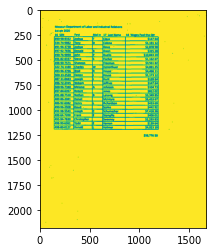

In [25]:
plt.imshow(image)

In [7]:
way = '/home/vimal/Documents/table_detect_samples/pre'

In [8]:
files = os.listdir(path)

In [9]:
main(files)

error: OpenCV(4.5.1) /tmp/pip-req-build-ms668fyv/opencv/modules/imgproc/src/smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'GaussianBlur'


In [5]:
image

NameError: name 'image' is not defined

In [38]:
import os
import cv2

def find_tables(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE,
    )

    MIN_TABLE_AREA = 1e5
    contours = [c for c in contours if cv2.contourArea(c) > MIN_TABLE_AREA]
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.1 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

    # The link where a lot of this code was borrowed from recommends an
    # additional step to check the number of "joints" inside this bounding rectangle.
    # A table should have a lot of intersections. We might have a rectangular image
    # here though which would only have 4 intersections, 1 at each corner.
    # Leaving that step as a future TODO if it is ever necessary.
    images = [image[y:y+h, x:x+w] for x, y, w, h in bounding_rects]
    return images

In [39]:
image = '/home/vimal/Documents/table_detect_samples/pre/0121023000.jpeg'

In [40]:
image = cv2.imread(image,0)

In [41]:
find_tables(image)

[array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)]

In [42]:
def main(files):
    results = []
    for f in files:
        directory, filename = os.path.split(f)
        #image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        image = io.imread(os.path.join(files,f),0)
        tables = find_tables(image)
        files = []
        filename_sans_extension = os.path.splitext(filename)[0]
        if tables:
            os.makedirs(os.path.join(directory, filename_sans_extension), exist_ok=True)
        for i, table in enumerate(tables):
            table_filename = "table-{:03d}.png".format(i)
            table_filepath = os.path.join(
                directory, filename_sans_extension, table_filename
            )
            files.append(table_filepath)
            cv2.imwrite(table_filepath, table)
        if tables:
            results.append((f, files))
    # Results is [[<input image>, [<images of detected tables>]]]
    return results

In [43]:
way = '/home/vimal/Documents/table_detect_samples/pre'

In [44]:
files = os.listdir(way)

In [42]:
import os
import cv2

In [43]:
def find_tables(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE,
    )

    MIN_TABLE_AREA = 1e5
    contours = [c for c in contours if cv2.contourArea(c) > MIN_TABLE_AREA]
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.1 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

    # The link where a lot of this code was borrowed from recommends an
    # additional step to check the number of "joints" inside this bounding rectangle.
    # A table should have a lot of intersections. We might have a rectangular image
    # here though which would only have 4 intersections, 1 at each corner.
    # Leaving that step as a future TODO if it is ever necessary.
    images = [image[y:y+h, x:x+w] for x, y, w, h in bounding_rects]
    return images

def main(files):
    file_path = '/home/vimal/Documents/table_detect_samples/pre'
    files = os.listdir(file_path)
    results = []
    for f in files:
        directory, filename = os.path.split(f)
        #image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(os.path.join(file_path,f),0)
        tables = find_tables(image)
        files = []
        filename_sans_extension = os.path.splitext(filename)[0]
        if tables:
            os.makedirs(os.path.join(directory, filename_sans_extension), exist_ok=True)
        for i, table in enumerate(tables):
            table_filename = "table-{:03d}.png".format(i)
            table_filepath = os.path.join(
                directory, filename_sans_extension, table_filename
            )
            files.append(table_filepath)
            cv2.imwrite(table_filepath, table)
        if tables:
            results.append((f, files))
    # Results is [[<input image>, [<images of detected tables>]]]
    return results

In [27]:
file_path = '/home/vimal/Documents/table_detect_samples/pre'

In [28]:
files = os.listdir(file_path)

In [29]:
main(files)

[('0621200000.jpeg', ['0621200000/table-000.png']),
 ('0444393000.jpeg', ['0444393000/table-000.png']),
 ('0798117000.jpeg', ['0798117000/table-000.png', '0798117000/table-001.png']),
 ('0113647000.jpeg', ['0113647000/table-000.png', '0113647000/table-001.png']),
 ('0121023000.jpeg', ['0121023000/table-000.png']),
 ('0890280000.jpeg', ['0890280000/table-000.png']),
 ('0782492000.jpeg', ['0782492000/table-000.png'])]

In [30]:
import argparse

from table_ocr.extract_tables import main

In [46]:
def find_tables(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE,
    )

    MIN_TABLE_AREA = 1e5
    contours = [c for c in contours if cv2.contourArea(c) > MIN_TABLE_AREA]
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.1 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

    # The link where a lot of this code was borrowed from recommends an
    # additional step to check the number of "joints" inside this bounding rectangle.
    # A table should have a lot of intersections. We might have a rectangular image
    # here though which would only have 4 intersections, 1 at each corner.
    # Leaving that step as a future TODO if it is ever necessary.
    images = [image[y:y+h, x:x+w] for x, y, w, h in bounding_rects]
    return images

def main(files):
    file_path = '/home/vimal/Documents/table_detect_samples/pre'
    files = os.listdir(file_path)
    results = []
    for f in files:
        directory, filename = os.path.split(f)
        #image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(os.path.join(file_path,f),0)
        tables = find_tables(image)
        files = []
        filename_sans_extension = os.path.splitext(filename)[0]
        if tables:
            os.makedirs(os.path.join(directory, filename_sans_extension), exist_ok=True)
        for i, table in enumerate(tables):
            table_filename = "table-{:03d}.png".format(i)
            table_filepath = os.path.join(
                directory, filename_sans_extension, table_filename
            )
            files.append(table_filepath)
            cv2.imwrite(table_filepath, table)
        if tables:
            results.append((f, files))
    # Results is [[<input image>, [<images of detected tables>]]]
    return results

#import argparse

#from table_ocr.extract_tables import main

#parser = argparse.ArgumentParser()
#parser.add_argument("files", nargs="+")
#args = parser.parse_args()
#files = args.files
#results = main(files)
#for image, tables in results:
#    print("\n".join(tables))

In [40]:
file_path = '/home/vimal/Documents/table_detect_samples/pre'
files = os.listdir(file_path)

In [47]:
main(files)

[('0621200000.jpeg', ['0621200000/table-000.png']),
 ('0444393000.jpeg', ['0444393000/table-000.png']),
 ('0798117000.jpeg', ['0798117000/table-000.png', '0798117000/table-001.png']),
 ('0113647000.jpeg', ['0113647000/table-000.png', '0113647000/table-001.png']),
 ('0121023000.jpeg', ['0121023000/table-000.png']),
 ('0890280000.jpeg', ['0890280000/table-000.png']),
 ('0782492000.jpeg', ['0782492000/table-000.png'])]

In [11]:
import matplotlib.pyplot as plt

In [14]:
for i in files:
    img = cv2.imread(os.path.join(file_path,i),0)
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(img, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    
    

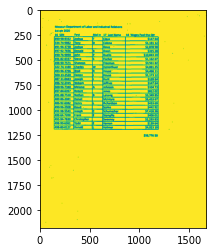

In [15]:
plt.imshow(img)

In [16]:
blurred

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [35]:
from PIL import Image
import glob
#image_list = []
for filename in glob.glob('/home/vimal/Documents/table_detect_samples/pre/*.jpeg'): #assuming gif
    im=cv2.imread(filename,0)
    #image_list.append(im)
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)

error: OpenCV(4.5.1) /tmp/pip-req-build-ms668fyv/opencv/modules/imgproc/src/smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'GaussianBlur'


In [28]:
import matplotlib.pyplot as plt
for i in files:
    print(i)
    image = cv2.imread(i)
    
    
    #BLUR_KERNEL_SIZE = (17, 17)
    #STD_DEV_X_DIRECTION = 0
    #STD_DEV_Y_DIRECTION = 0
    #blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    #image.show()

0298801000.jpeg
0621200000.jpeg
0444393000.jpeg
0347682000.jpeg
0134407000.jpeg
0113647000.jpeg
0121023000.jpeg
0890280000.jpeg
0782492000.jpeg


In [37]:
image = cv2.imread('/home/vimal/Documents/table_detect_samples/pre/0121023000.jpeg')
BLUR_KERNEL_SIZE = (17, 17)
STD_DEV_X_DIRECTION = 0
STD_DEV_Y_DIRECTION = 0
blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)


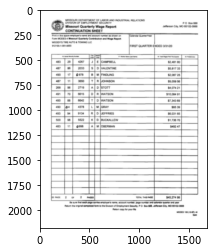

In [39]:
plt.imshow(blurred)

In [38]:
blurred

array([[[227, 227, 227],
        [224, 224, 224],
        [214, 214, 214],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[227, 227, 227],
        [224, 224, 224],
        [214, 214, 214],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[228, 228, 228],
        [225, 225, 225],
        [215, 215, 215],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [ ]:
file_path = '/home/vimal/Documents/table_detect_samples/pre'
    files = os.listdir(file_path)
    results = []
    for f in files:
        directory, filename = os.path.split(f)
        #image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(os.path.join(file_path,f),0)

In [32]:
import cv2
import os

In [37]:
def extract_cell_images_from_table(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,
    )
    
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.05 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    
    # Filter out contours that aren't rectangular. Those that aren't rectangular
    # are probably noise.
    approx_rects = [p for p in approx_polys if len(p) == 4]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]
    
    # Filter out rectangles that are too narrow or too short.
    MIN_RECT_WIDTH = 40
    MIN_RECT_HEIGHT = 10
    bounding_rects = [
        r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
    ]
    
    # The largest bounding rectangle is assumed to be the entire table.
    # Remove it from the list. We don't want to accidentally try to OCR
    # the entire table.
    largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
    bounding_rects = [b for b in bounding_rects if b is not largest_rect]
    
    cells = [c for c in bounding_rects]
    def cell_in_same_row(c1, c2):
        c1_center = c1[1] + c1[3] - c1[3] / 2
        c2_bottom = c2[1] + c2[3]
        c2_top = c2[1]
        return c2_top < c1_center < c2_bottom
    
    orig_cells = [c for c in cells]
    rows = []
    while cells:
        first = cells[0]
        rest = cells[1:]
        cells_in_same_row = sorted(
            [
                c for c in rest
                if cell_in_same_row(c, first)
            ],
            key=lambda c: c[0]
        )
    
        row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
        rows.append(row_cells)
        cells = [
            c for c in rest
            if not cell_in_same_row(c, first)
        ]
    
    # Sort rows by average height of their center.
    def avg_height_of_center(row):
        centers = [y + h - h / 2 for x, y, w, h in row]
        return sum(centers) / len(centers)
    
    rows.sort(key=avg_height_of_center)
    cell_images_rows = []
    for row in rows:
        cell_images_row = []
        for x, y, w, h in row:
            cell_images_row.append(image[y:y+h, x:x+w])
        cell_images_rows.append(cell_images_row)
    return cell_images_rows

def main(files):
    file_path = '/home/vimal/Documents/table_detect_samples/pre'
    files = os.listdir(file_path)
    
    results = []
    for f in files:
        directory, filename = os.path.split(f)
        #table = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        table = cv2.imread(os.path.join(file_path,f),0)
        rows = extract_cell_images_from_table(table)
        cell_img_dir = os.path.join(directory, "cells")
        os.makedirs(cell_img_dir, exist_ok=True)
        paths = []
        for i, row in enumerate(rows):
            for j, cell in enumerate(row):
                cell_filename = "{:03d}-{:03d}.png".format(i, j)
                path = os.path.join(cell_img_dir, cell_filename)
                cv2.imwrite(path, cell)
                paths.append(path)
        return paths

In [ ]:
file_path = '/home/vimal/Documents/table_detect_samples/pre'
    files = os.listdir(file_path)
    results = []
    for f in files:
        directory, filename = os.path.split(f)
        #image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(os.path.join(file_path,f),0)

In [48]:
import cv2
import os

def extract_cell_images_from_table(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,
    )
    
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.05 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    
    # Filter out contours that aren't rectangular. Those that aren't rectangular
    # are probably noise.
    approx_rects = [p for p in approx_polys if len(p) == 4]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]
    
    # Filter out rectangles that are too narrow or too short.
    MIN_RECT_WIDTH = 40
    MIN_RECT_HEIGHT = 10
    bounding_rects = [
        r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
    ]
    
    # The largest bounding rectangle is assumed to be the entire table.
    # Remove it from the list. We don't want to accidentally try to OCR
    # the entire table.
    largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
    bounding_rects = [b for b in bounding_rects if b is not largest_rect]
    
    cells = [c for c in bounding_rects]
    def cell_in_same_row(c1, c2):
        c1_center = c1[1] + c1[3] - c1[3] / 2
        c2_bottom = c2[1] + c2[3]
        c2_top = c2[1]
        return c2_top < c1_center < c2_bottom
    
    orig_cells = [c for c in cells]
    rows = []
    while cells:
        first = cells[0]
        rest = cells[1:]
        cells_in_same_row = sorted(
            [
                c for c in rest
                if cell_in_same_row(c, first)
            ],
            key=lambda c: c[0]
        )
    
        row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
        rows.append(row_cells)
        cells = [
            c for c in rest
            if not cell_in_same_row(c, first)
        ]
    
    # Sort rows by average height of their center.
    def avg_height_of_center(row):
        centers = [y + h - h / 2 for x, y, w, h in row]
        return sum(centers) / len(centers)
    
    rows.sort(key=avg_height_of_center)
    cell_images_rows = []
    for row in rows:
        cell_images_row = []
        for x, y, w, h in row:
            cell_images_row.append(image[y:y+h, x:x+w])
        cell_images_rows.append(cell_images_row)
    return cell_images_rows

def main(f):
    results = []
    directory, filename = os.path.split(f)
    table = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    rows = extract_cell_images_from_table(table)
    cell_img_dir = os.path.join(directory, "cells")
    os.makedirs(cell_img_dir, exist_ok=True)
    paths = []
    for i, row in enumerate(rows):
        for j, cell in enumerate(row):
            cell_filename = "{:03d}-{:03d}.png".format(i, j)
            path = os.path.join(cell_img_dir, cell_filename)
            cv2.imwrite(path, cell)
            paths.append(path)
    return paths

In [51]:
f = '/home/vimal/Documents/table_detect_samples/pre/0121023000.jpeg'

In [52]:
main(f)

['/home/vimal/Documents/table_detect_samples/pre/cells/000-000.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/000-001.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/000-002.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/000-003.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/000-004.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/000-005.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/001-000.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/001-001.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/001-002.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/001-003.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/001-004.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/001-005.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/001-006.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/001-007.png',
 '/home/vimal/Documents/table_dete

In [54]:
import math
import os
import sys

import cv2
import numpy as np
import pytesseract

In [68]:
import math
import os
import sys

import cv2
import numpy as np
import pytesseract

def main(image_file, tess_args):
    """
    OCR the image and output the text to a file with an extension that is ready
    to be used in Tesseract training (.gt.txt).
    Tries to crop the image so that only the relevant text gets passed to Tesseract.
    Returns the name of the text file that contains the text.
    """
    directory, filename = os.path.split(image_file)
    filename_sans_ext, ext = os.path.splitext(filename)
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    cropped = crop_to_text(image)
    ocr_data_dir = os.path.join(directory, "ocr_data")
    os.makedirs(ocr_data_dir, exist_ok=True)
    out_imagepath = os.path.join(ocr_data_dir, filename)
    out_txtpath = os.path.join(ocr_data_dir, "{}.gt.txt".format(filename_sans_ext))
    cv2.imwrite(out_imagepath, cropped)
    if not tess_args:
        d = os.path.dirname(sys.modules["table_ocr"].__file__)
        tessdata_dir = os.path.join(d, "tessdata")
        tess_args = ["--psm", "7", "-l", "table-ocr", "--tessdata-dir", tessdata_dir]
    txt = ocr_image(cropped, " ".join(tess_args))
    with open(out_txtpath, "w") as txt_file:
        txt_file.write(txt)
    return out_txtpath
def crop_to_text(image):
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2

    img_bin = cv2.adaptiveThreshold(
        ~image,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )

    img_h, img_w = image.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(img_w * 0.5), 1))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(img_h * 0.7)))
    horizontal_lines = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_lines = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    both = horizontal_lines + vertical_lines
    cleaned = img_bin - both

    # Get rid of little noise.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opened = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)
    opened = cv2.dilate(opened, kernel)

    contours, hierarchy = cv2.findContours(opened, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    bounding_rects = [cv2.boundingRect(c) for c in contours]
    NUM_PX_COMMA = 6
    MIN_CHAR_AREA = 5 * 9
    char_sized_bounding_rects = [(x, y, w, h) for x, y, w, h in bounding_rects if w * h > MIN_CHAR_AREA]
    if char_sized_bounding_rects:
        minx, miny, maxx, maxy = math.inf, math.inf, 0, 0
        for x, y, w, h in char_sized_bounding_rects:
            minx = min(minx, x)
            miny = min(miny, y)
            maxx = max(maxx, x + w)
            maxy = max(maxy, y + h)
        x, y, w, h = minx, miny, maxx - minx, maxy - miny
        cropped = image[y:min(img_h, y+h+NUM_PX_COMMA), x:min(img_w, x+w)]
    else:
        # If we morphed out all of the text, assume an empty image.
        cropped = MAX_COLOR_VAL * np.ones(shape=(20, 100), dtype=np.uint8)
    bordered = cv2.copyMakeBorder(cropped, 5, 5, 5, 5, cv2.BORDER_CONSTANT, None, 255)
    return bordered
def ocr_image(image, config):
    return pytesseract.image_to_string(
        image,
        config=config
    )

In [69]:
image_file = '/home/vimal/Documents/table_detect_samples/pre/table_extracted/0782492000/table-000.png'
tess_args = '/home/vimal/Documents/table_detect_samples/pre/table_extracted/0782492000/table-000.png'
main(image_file, tess_args)

In [70]:
main(image_file, tess_args)

'/home/vimal/Documents/table_detect_samples/pre/table_extracted/0782492000/ocr_data/table-000.gt.txt'

In [84]:
import csv
import io
import os


def text_files_to_csv(files):
    """Files must be sorted lexicographically
    Filenames must be <row>-<colum>.txt.
    000-000.txt
    000-001.txt
    001-000.txt
    etc...
    """
    rows = []
    for f in files:
        directory, filename = os.path.split(f)
        with open(file_way,f) as of:
            txt = of.read().strip()
        row, column = map(int, filename.split(".")[0].split("-"))
        if row == len(rows):
            rows.append([])
        rows[row].append(txt)

    csv_file = io.StringIO()
    writer = csv.writer(csv_file)
    writer.writerows(rows)
    return csv_file.getvalue()

def main(files):
    return text_files_to_csv(files)

In [85]:
file_way = '/home/vimal/Documents/table_detect_samples/pre/table_extracted/txt files'

In [86]:
files = os.listdir(file_way)

In [88]:
main(files)

ValueError: invalid mode: 'table-001.txt'

In [79]:
for f in files:
    print(f)
    with open(f) as of:
        text = of.read().strip()

table-001.gt.txt


FileNotFoundError: [Errno 2] No such file or directory: 'table-001.gt.txt'

# TABLE-OCR (Table_extraction)

In [ ]:
def find_tables(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE,
    )

    MIN_TABLE_AREA = 1e5
    contours = [c for c in contours if cv2.contourArea(c) > MIN_TABLE_AREA]
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.1 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

    # The link where a lot of this code was borrowed from recommends an
    # additional step to check the number of "joints" inside this bounding rectangle.
    # A table should have a lot of intersections. We might have a rectangular image
    # here though which would only have 4 intersections, 1 at each corner.
    # Leaving that step as a future TODO if it is ever necessary.
    images = [image[y:y+h, x:x+w] for x, y, w, h in bounding_rects]
    return images

def main(files):
    file_path = '/home/vimal/Documents/table_detect_samples/pre'
    files = os.listdir(file_path)
    results = []
    for f in files:
        directory, filename = os.path.split(f)
        #image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(os.path.join(file_path,f),0)
        tables = find_tables(image)
        files = []
        filename_sans_extension = os.path.splitext(filename)[0]
        if tables:
            os.makedirs(os.path.join(directory, filename_sans_extension), exist_ok=True)
        for i, table in enumerate(tables):
            table_filename = "table-{:03d}.png".format(i)
            table_filepath = os.path.join(
                directory, filename_sans_extension, table_filename
            )
            files.append(table_filepath)
            cv2.imwrite(table_filepath, table)
        if tables:
            results.append((f, files))
    # Results is [[<input image>, [<images of detected tables>]]]
    return results



In [ ]:
file_path = '/home/vimal/Documents/table_detect_samples/pre'
files = os.listdir(file_path)

In [ ]:
main(files)

#  TABLE-OCR (Cells_extraction)

In [25]:
import cv2
import os

def extract_cell_images_from_table(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,
    )
    
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.05 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    
    # Filter out contours that aren't rectangular. Those that aren't rectangular
    # are probably noise.
    approx_rects = [p for p in approx_polys if len(p) == 4]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]
    
    # Filter out rectangles that are too narrow or too short.
    MIN_RECT_WIDTH = 40
    MIN_RECT_HEIGHT = 10
    bounding_rects = [
        r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
    ]
    
    # The largest bounding rectangle is assumed to be the entire table.
    # Remove it from the list. We don't want to accidentally try to OCR
    # the entire table.
    largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
    bounding_rects = [b for b in bounding_rects if b is not largest_rect]
    
    cells = [c for c in bounding_rects]
    def cell_in_same_row(c1, c2):
        c1_center = c1[1] + c1[3] - c1[3] / 2
        c2_bottom = c2[1] + c2[3]
        c2_top = c2[1]
        return c2_top < c1_center < c2_bottom
    
    orig_cells = [c for c in cells]
    rows = []
    while cells:
        first = cells[0]
        rest = cells[1:]
        cells_in_same_row = sorted(
            [
                c for c in rest
                if cell_in_same_row(c, first)
            ],
            key=lambda c: c[0]
        )
    
        row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
        rows.append(row_cells)
        cells = [
            c for c in rest
            if not cell_in_same_row(c, first)
        ]
    
    # Sort rows by average height of their center.
    def avg_height_of_center(row):
        centers = [y + h - h / 2 for x, y, w, h in row]
        return sum(centers) / len(centers)
    
    rows.sort(key=avg_height_of_center)
    cell_images_rows = []
    for row in rows:
        cell_images_row = []
        for x, y, w, h in row:
            cell_images_row.append(image[y:y+h, x:x+w])
        cell_images_rows.append(cell_images_row)
    return cell_images_rows

def main(f):
    results = []
    directory, filename = os.path.split(f)
    table = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    rows = extract_cell_images_from_table(table)
    cell_img_dir = os.path.join(directory, "cells")
    os.makedirs(cell_img_dir, exist_ok=True)
    paths = []
    for i, row in enumerate(rows):
        for j, cell in enumerate(row):
            cell_filename = "{:03d}-{:03d}.png".format(i, j)
            path = os.path.join(cell_img_dir, cell_filename)
            cv2.imwrite(path, cell)
            paths.append(path)
    return paths

In [26]:
f = '/home/vimal/Documents/table_detect_samples/pre/0782492000.jpeg'


In [27]:
main(f)

['/home/vimal/Documents/table_detect_samples/pre/cells/000-000.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/000-001.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/000-002.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/000-003.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/000-004.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/001-000.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/001-001.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/001-002.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/001-003.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/001-004.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/002-000.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/002-001.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/002-002.png',
 '/home/vimal/Documents/table_detect_samples/pre/cells/002-003.png',
 '/home/vimal/Documents/table_dete

# # TABLE-OCR (Text_extraction)

In [1]:
import math
import os
import sys

import cv2
import numpy as np
import pytesseract

def main(image_file, tess_args):
    """
    OCR the image and output the text to a file with an extension that is ready
    to be used in Tesseract training (.gt.txt).
    Tries to crop the image so that only the relevant text gets passed to Tesseract.
    Returns the name of the text file that contains the text.
    """
    directory, filename = os.path.split(image_file)
    filename_sans_ext, ext = os.path.splitext(filename)
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    cropped = crop_to_text(image)
    ocr_data_dir = os.path.join(directory, "ocr_data")
    os.makedirs(ocr_data_dir, exist_ok=True)
    out_imagepath = os.path.join(ocr_data_dir, filename)
    out_txtpath = os.path.join(ocr_data_dir, "{}.gt.txt".format(filename_sans_ext))
    cv2.imwrite(out_imagepath, cropped)
    if not tess_args:
        d = os.path.dirname(sys.modules["table_ocr"].__file__)
        tessdata_dir = os.path.join(d, "tessdata")
        tess_args = ["--psm", "7", "-l", "table-ocr", "--tessdata-dir", tessdata_dir]
    txt = ocr_image(cropped, " ".join(tess_args))
    with open(out_txtpath, "w") as txt_file:
        txt_file.write(txt)
    return out_txtpath
def crop_to_text(image):
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2

    img_bin = cv2.adaptiveThreshold(
        ~image,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )

    img_h, img_w = image.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(img_w * 0.5), 1))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(img_h * 0.7)))
    horizontal_lines = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_lines = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    both = horizontal_lines + vertical_lines
    cleaned = img_bin - both

    # Get rid of little noise.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opened = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)
    opened = cv2.dilate(opened, kernel)

    contours, hierarchy = cv2.findContours(opened, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    bounding_rects = [cv2.boundingRect(c) for c in contours]
    NUM_PX_COMMA = 6
    MIN_CHAR_AREA = 5 * 9
    char_sized_bounding_rects = [(x, y, w, h) for x, y, w, h in bounding_rects if w * h > MIN_CHAR_AREA]
    if char_sized_bounding_rects:
        minx, miny, maxx, maxy = math.inf, math.inf, 0, 0
        for x, y, w, h in char_sized_bounding_rects:
            minx = min(minx, x)
            miny = min(miny, y)
            maxx = max(maxx, x + w)
            maxy = max(maxy, y + h)
        x, y, w, h = minx, miny, maxx - minx, maxy - miny
        cropped = image[y:min(img_h, y+h+NUM_PX_COMMA), x:min(img_w, x+w)]
    else:
        # If we morphed out all of the text, assume an empty image.
        cropped = MAX_COLOR_VAL * np.ones(shape=(20, 100), dtype=np.uint8)
    bordered = cv2.copyMakeBorder(cropped, 5, 5, 5, 5, cv2.BORDER_CONSTANT, None, 255)
    return bordered
def ocr_image(image, config):
    return pytesseract.image_to_string(
        image,
        config=config
    )

In [2]:
image_file = '/home/vimal/Documents/table_detect_samples/pre/table_extracted/0347682000/0347682000.jpeg'
tess_args = '/home/vimal/Documents/table_detect_samples/pre/table_extracted/0347682000/0347682000.jpeg'


In [3]:
main(image_file, tess_args)

'/home/vimal/Documents/table_detect_samples/pre/table_extracted/0347682000/ocr_data/0347682000.gt.txt'

In [1]:
def find_tables(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE,
    )

    MIN_TABLE_AREA = 1e5
    contours = [c for c in contours if cv2.contourArea(c) > MIN_TABLE_AREA]
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.1 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

    # The link where a lot of this code was borrowed from recommends an
    # additional step to check the number of "joints" inside this bounding rectangle.
    # A table should have a lot of intersections. We might have a rectangular image
    # here though which would only have 4 intersections, 1 at each corner.
    # Leaving that step as a future TODO if it is ever necessary.
    images = [image[y:y+h, x:x+w] for x, y, w, h in bounding_rects]
    return images

def main(files):
    file_path = '/home/vimal/Documents/table_detect_samples/tables_extract'
    files = os.listdir(file_path)
    results = []
    for f in files:
        directory, filename = os.path.split(f)
        #image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(os.path.join(file_path,f),0)
        tables = find_tables(image)
        files = []
        filename_sans_extension = os.path.splitext(filename)[0]
        if tables:
            os.makedirs(os.path.join(directory, filename_sans_extension), exist_ok=True)
        for i, table in enumerate(tables):
            table_filename = "table-{:03d}.png".format(i)
            table_filepath = os.path.join(
                directory, filename_sans_extension, table_filename
            )
            files.append(table_filepath)
            cv2.imwrite(table_filepath, table)
        if tables:
            results.append((f, files))
    # Results is [[<input image>, [<images of detected tables>]]]
    return results



In [4]:
file_path = '/home/vimal/Documents/table_detect_samples/tables_extract'
files = os.listdir(file_path)

In [6]:
import os
import cv2

In [7]:
main(files)

[('0621200000.jpeg', ['0621200000/table-000.png']),
 ('0146902000.jpeg', ['0146902000/table-000.png', '0146902000/table-001.png']),
 ('0444393000.jpeg', ['0444393000/table-000.png']),
 ('0798117000.jpeg', ['0798117000/table-000.png', '0798117000/table-001.png']),
 ('0298300000.jpeg', ['0298300000/table-000.png']),
 ('0113647000.jpeg', ['0113647000/table-000.png', '0113647000/table-001.png']),
 ('0121023000.jpeg', ['0121023000/table-000.png']),
 ('0890280000.jpeg', ['0890280000/table-000.png']),
 ('0782492000.jpeg', ['0782492000/table-000.png'])]

In [ ]:
import csv
import io
import os


def text_files_to_csv(files):
    """Files must be sorted lexicographically
    Filenames must be <row>-<colum>.txt.
    000-000.txt
    000-001.txt
    001-000.txt
    etc...
    """
    rows = []
    for f in files:
        directory, filename = os.path.split(f)
        with open(f) as of:
            txt = of.read().strip()
        row, column = map(int, filename.split(".")[0].split("-"))
        if row == len(rows):
            rows.append([])
        rows[row].append(txt)

    csv_file = io.StringIO()
    writer = csv.writer(csv_file)
    writer.writerows(rows)
    return csv_file.getvalue()

def main(files):
    return text_files_to_csv(files)